# ReadtheDocs Retrieval Augmented Generation (RAG)

In this notebook, we are going to use Milvus documentation pages to create a chatbot about our product.  The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.

Many RAG demos use OpenAI for the Embedding Model and ChatGPT for the Generative AI model.  **In this notebook, we will demo a fully open source RAG stack.**

Using open-source Q&A with retrieval saves money since we make free calls to our own data almost all the time - retrieval, evaluation, and development iterations.

<div>
<img src="../../../images/rag_image.png" width="80%"/>
</div>

Let's get started!

In [1]:
# For colab install these libraries in this order:
# !python -m pip install torch transformers sentence-transformers langchain
# !python -m pip install -U pymilvus
# !python -m pip install unstructured openai tqdm numpy ipykernel 
# !python -m pip install ragas datasets

In [2]:
# Import common libraries.
import sys, os, time, pprint

# # Import custom functions for splitting and search.
# sys.path.append("../..")  # Adds higher directory to python modules path.
# import milvus_utilities as _utils

import grpc
from concurrent.futures import ThreadPoolExecutor

# Server side.
server = grpc.server(ThreadPoolExecutor(max_workers=10),
                     options=[('grpc.max_receive_message_length', 50 * 1024 * 1024)])  # 50 MB

# Client side.
channel = grpc.insecure_channel('localhost:50051',
                                options=[('grpc.max_send_message_length', 50 * 1024 * 1024)])  # 50 MB

In [3]:
# Function to remove newlines and double spaces from a string.
def clean_text(text):
    clean_text = text.replace("\n\n", " ")\
                     .replace("\n", " ")\
                     .replace("<br><br>", " ")\
                     .replace("<br /><br />", " ")
    
    # Remove extra whitespace.
    clean_text = ' '.join(clean_text.split())
    return clean_text

import numpy as np
import matplotlib.pyplot as plt

# Function to inspect chunk lengths in matplotlit.
def plot_chunk_lengths(chunked_docs, title_keyword):
    # Get chunk lengths.
    lengths = [len(doc.page_content) for doc in chunked_docs]

    # Mean, median lengths.
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)

    # Assemble the title.
    title = f"Chunk Lengths from {title_keyword} Chunking"

    # Plot the lengths.
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.plot(lengths, marker='o')  # Plot lengths with circle markers
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Document Index')  # X-axis label
    plt.ylabel('Length')  # Y-axis label
    plt.grid(True)  # Show grid

    # Add a horizontal line at mean and median length
    plt.axhline(y=mean_length, color='g', linestyle='-')
    plt.axhline(y=median_length, color='r', linestyle='-')
    plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
    plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

    plt.show()  # Display the plot

## Download Data

The data used in this notebook is Milvus documentation web pages.

The code block below downloads all the web pages into a local directory called `rtdocs`.  

I've already uploaded the `rtdocs` data folder to github, so you should see it if you cloned my repo.

In [4]:
# UNCOMMENT TO DOWNLOAD THE DOCS.

# !pip install -U langchain
from langchain_community.document_loaders import RecursiveUrlLoader

DOCS_PAGE="https://milvus.io/docs/"

loader = RecursiveUrlLoader(DOCS_PAGE)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# # Subset docs for faster testing
# docs = docs[5:7].copy()
# num_documents = len(docs)
# print(f"testing with {num_documents} documents")

# Print the type of the docs.
print(type(docs))
print(type(docs[0]))

docs[0].page_content[:500]

loaded 23 documents
<class 'list'>
<class 'langchain_core.documents.base.Document'>


'<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><link rel="icon" href="/favicon-32x32.png"/><meta name="image" property="og:image" content="https://assets.zilliz.com/meta_image_milvus_d6510e10e0.png"/><meta property="og:type" content="WebSite"/><title>Milvus vector database documentation</title><meta name="description" content="Milvus v2.4.x documentation"/><meta property="og:title" content="Milvus vector database documentation"/><m'

In [5]:
# # Save Langchain docs to a local directory.
# OUTPUT_DIR = "../../RAG/rtdocs_new/"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Convert each doc to HTML and save to the specified directory
# for doc in docs:
#     # Extract file name
#     filename = doc.metadata['source'].split('/')[-1].replace(".md", ".html")
    
#     # Check that filename is not empty
#     if filename:
#         with open(os.path.join(OUTPUT_DIR, filename), "w") as f:
#             f.write(doc.page_content)
#     else:
#         print("Filename is empty. Skipping this doc.")
#         pprint.pprint(doc.metadata)
#         pprint.pprint(doc.page_content[:500])

## Load the Embedding Model checkpoint and use it to create vector embeddings

#### What are Embeddings?

Check out [this blog](https://zilliz.com/glossary/vector-embeddings) for an introduction to embeddings.  

An excellent place to start is by selecting an embedding model from the [HuggingFace MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.  

Milvus (and Zilliz) only supports tested embedding models that are **not overfit**!

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

# Use an embedding model.
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
embed_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
EMBEDDING_DIM = embed_model.dict()['client'].get_sentence_embedding_dimension()
print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MODEL: BAAI/bge-large-en-v1.5, EMBEDDING_DIM: 1024


In [7]:
# !python -m pip install --upgrade langchain_openai

In [8]:
# from langchain_openai.embeddings import OpenAIEmbeddings

# # 1. Get your API key: https://platform.openai.com/api-keys
# # 2. Save your api key in env variable.
# # https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

# # 3. OpenAI embedding model name, `text-embedding-3-large` or `ext-embedding-3-small`.
# # release notes: https://openai.com/index/new-embedding-models-and-api-updates/
# model_name = "text-embedding-3-small"
# EMBEDDING_DIM = 512

# model_kwargs = {'device': 'cpu'}
# embed_model = OpenAIEmbeddings(
#     model=model_name,
#     dimensions=EMBEDDING_DIM,
#     model_kwargs=model_kwargs
# )
# print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

## HTML Chunking using LangChain

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap.  This section uses:
- **Strategy** = Use markdown header hierarchies.  Keep markdown sections together unless they are too long.
- **Chunk size** = Use the embedding model's parameter `MAX_SEQ_LENGTH`
- **Overlap** = Rule-of-thumb 10-15%
- **Function** = 
  - Langchain's `HTMLHeaderTextSplitter` to split markdown sections.
  - Langchain's `RecursiveCharacterTextSplitter` to split up long reviews recursively.


Notice below, each chunk is grounded with the document source page.  <br>
In addition, header titles are kept together with the chunk of markdown text.

In [9]:
# !python -m pip install lxml
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter
import uuid, re

doc_ids = [str(uuid.uuid4()) for _ in docs]

# Define the headers to split on for the HTMLHeaderTextSplitter
headers_to_split_on = [
    ("<h1>", "Header 1"),
    ("<h2>", "Header 2"),
    ("<h3>", "Header 3"),
]
# Create an instance of the HTMLHeaderTextSplitter
html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Construct a regex pattern to match any of the specified headers
pattern = '|'.join(re.escape(header[0]) for header in headers_to_split_on)
# More complex pattern to match opening, closing, and self-closing tags.
pattern = r"<h[1-3](?: [^>]*)?>|</h[1-3]>|<h[1-3](?: [^>]*)?/>"
print("Pattern for splitting:", pattern)

# Function to remove all HTML tags
def remove_html_tags(text):
    return re.sub(r"<[^>]+>", "", text)

# Split the HTML text using the HTMLHeaderTextSplitter.
html_docs = []
for doc_id, doc in zip(doc_ids, docs):

    # Grab the headers
    new_text = doc.page_content
    new_text = clean_text(new_text).replace('\n', ' ')
    html_split_list = re.split(pattern, new_text)
    # print(html_split_list[0])
    # Remove HTML tags from each extracted header text
    html_split_list = [remove_html_tags(header) for header in html_split_list]
    # print(html_split_list[0])
    # print(f"Split into {len(html_split_list)} parts.")

    # Split the text into chunks using the HTMLHeaderTextSplitter.
    splits = html_splitter.split_text(doc.page_content)

    for split in splits:

        # Clean the text.
        split.page_content = clean_text(split.page_content)

        # Assemble the metadata.
        metadata = {}
        # Handle exception if h1 does not exist.
        try:
            header_value1 = html_split_list[1].strip()[:25]
            metadata["h1"] = header_value1
            # print(f"header_name: h1, header_value: {header_value1}")
        except:
            break
        # Handle exception if h2 does not exist.
        try:
            header_value2 = html_split_list[2].strip()[:25]
            if len(header_value2) <= 0:
                header_value2 = html_split_list[3].strip()[:25]
            metadata["h2"] = header_value2
            # print(f"header_name: h2, header_value: {header_value2}")
        except:
            break
        # Handle exception if h2 does not exist.
        try:
            header_value3 = html_split_list[3].strip()[:25]
            if (len(header_value3) <= 0 or header_value3 == header_value2):
                header_value3 = html_split_list[4].strip()[:25]
            if header_value3 == header_value2:
                header_value3 = html_split_list[5].strip()[:25]
            metadata["h3"] = header_value3
            # print(f"header_name: h3, header_value: {header_value3}")
        except:
            break
        split.metadata = {
            **metadata,
            "source": doc.metadata["source"],
            'doc_index': doc_id
        }
    html_docs.extend(splits)

print(f"docs: {len(docs)}, split into {len(html_docs)} html chunks.")

# Inspect a chunk
print(html_docs[0].page_content[:200])
print(html_docs[0].metadata)

Pattern for splitting: <h[1-3](?: [^>]*)?>|</h[1-3]>|<h[1-3](?: [^>]*)?/>
docs: 23, split into 23 html chunks.
DocsBlogCommunity Why Milvus What is MilvusUse Cases Tutorials CodelabsBootcampDemosVideo Tools AttuMilvus CLISizing ToolMilvus Backup Get Started Docs Tutorials Tools Blog Community Get Started Searc
{'h1': 'Welcome to Milvus Docs!', 'h2': 'Here you will learn about', 'h3': '', 'source': 'https://milvus.io/docs/', 'doc_index': '5a75d188-5760-42ed-908a-b9c35c6998a2'}


In [10]:
# Inspect another chunk
print(html_docs[20].page_content[:200])
print(html_docs[20].metadata)

DocsBlogCommunity Why Milvus What is MilvusUse Cases Tutorials CodelabsBootcampDemosVideo Tools AttuMilvus CLISizing ToolMilvus Backup Get Started Docs Tutorials Tools Blog Community Get Started Searc
{'h1': 'Hybrid Search', 'h2': 'Since Milvus 2.4, we intr', 'h3': 'Preparations', 'source': 'https://milvus.io/docs/multi-vector-search.md', 'doc_index': 'd86ecd0c-39d2-432d-ac1e-a856274804af'}


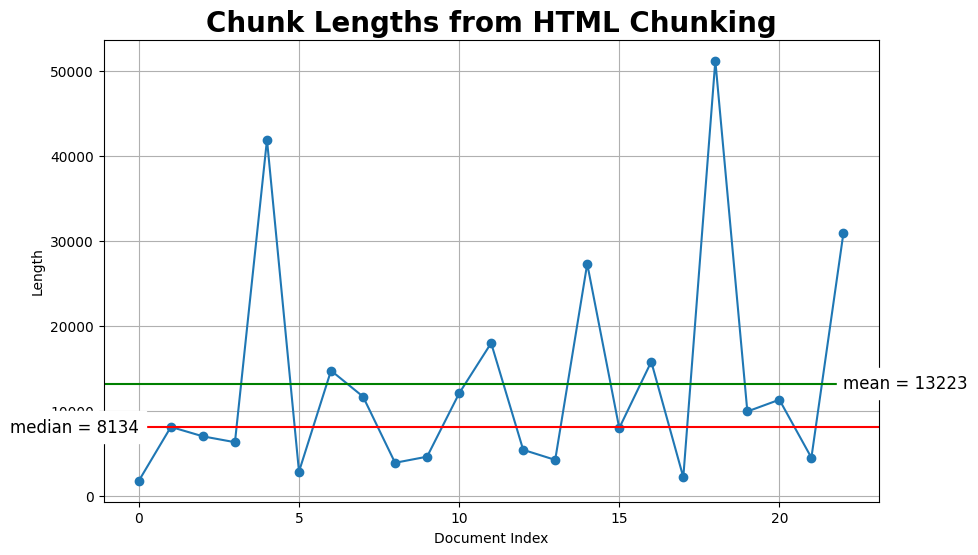

In [11]:
# Inspect chunk lengths
plot_chunk_lengths(html_docs, 'HTML')

## Small-to-Big using LangChain

Often times it can be useful to retrieve larger chunks of information, but embed smaller chunks. This allows for embeddings to capture the semantic meaning as closely as possible, but for as much context as possible to be passed downstream. Note that this is what the ParentDocumentRetriever does. Here we show what is going on under the hood.

> - The vector store indexes and searches embeddings of the smallest (sub) documents.  
> - The document store houses the "parent" documents and associates them with an identifier.

- See MultiVectorRetriever [api](https://api.python.langchain.com/en/latest/retrievers/langchain.retrievers.multi_vector.MultiVectorRetriever.html).
- See ParentDocumentRetriever [docs](https://python.langchain.com/v0.2/docs/how_to/multi_vector/#smaller-chunks) and [api](https://api.python.langchain.com/en/latest/retrievers/langchain.retrievers.parent_document_retriever.ParentDocumentRetriever.html).

In [12]:
# !python -m pip install lxml
from langchain_milvus import Milvus
from langchain.text_splitter import RecursiveCharacterTextSplitter
import time, pprint, uuid
import numpy as np
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Create doc storage for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
vectorstore = Milvus(
    collection_name=COLLECTION_NAME,
    embedding_function=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    auto_id=True,
    # Set to True to drop the existing collection if it exists.
    drop_old=True,
)

# The MultiVectorRetriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

In [85]:
PARENT_CHUNK_SIZE = 1586

# The splitter to use to create bigger (parent) chunks
parent_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
)
# From HTML chunks.
parent_docs = parent_text_splitter.split_documents(html_docs)

print(f"{len(html_docs)} docs split into {len(parent_docs)} parent documents.")
# inspect a parent doc.
print(parent_docs[0].page_content[:200])
pprint.pprint(parent_docs[0].metadata)

23 docs split into 3694 parent documents.
<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><link rel="icon" href="/favicon-32x32.png"/><meta name="image" property="og:image" conte


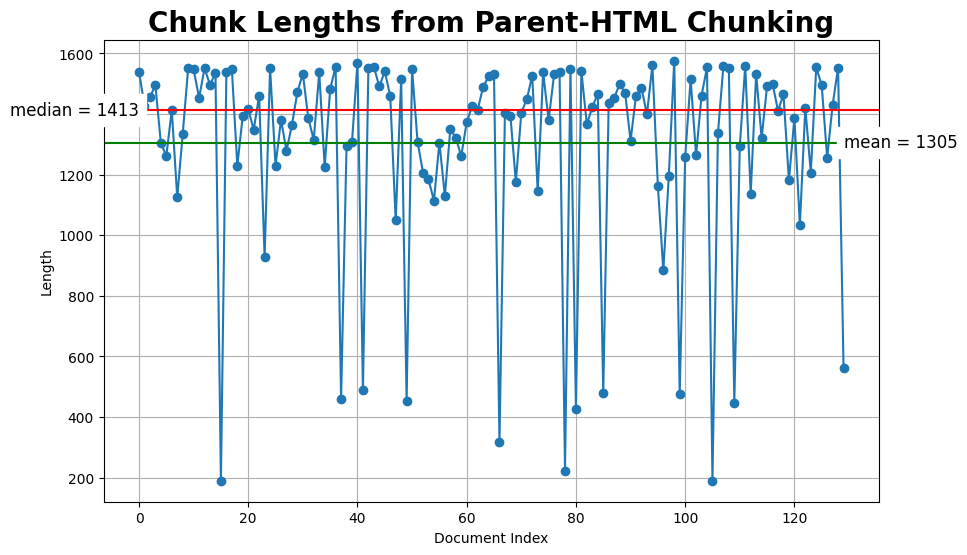

In [89]:
# Inspect chunk lengths
plot_chunk_lengths(parent_docs, 'Parent-HTML')

## Small-to-big Chunking without HTML chunking

In [86]:
# From raw docs

# UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# Read docs into LangChain
# !pip install -U langchain
# !pip install unstructured
from langchain.document_loaders import DirectoryLoader

# Load HTML files from a local directory
path = "../../RAG/rtdocs_new/"
global_pattern = '*.html'
loader = DirectoryLoader(path=path, glob=global_pattern)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# # Subset docs for faster testing
# docs = docs[5:7].copy()
# num_documents = len(docs)
# print(f"testing with {num_documents} documents")

# Print the type of the docs.
print(type(docs))
print(type(docs[0]))

docs[0].page_content[:500]

loaded 22 documents
<class 'list'>
<class 'langchain_core.documents.base.Document'>


'Why Milvus\n\nDocs\n\nTutorials\n\nTools\n\nBlog\n\nCommunity\n\nStars0\n\nTry Managed Milvus FREE\n\nSearch\n\nHome\n\nv2.4.x\n\nAbout Milvus\n\nGet StartedPrerequisitesInstall MilvusInstall SDKsQuickstart\n\nConcepts\n\nUser Guide\n\nModels\n\nAdministration Guide\n\nTools\n\nIntegrations\n\nExample Applications\n\nFAQs\n\nAPI reference\n\nQuickstart\n\nThis guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes\n\nBefore you start\n\nYou have installed Milvus standalone or Milvus cluster.\n\nYou have insta'

In [88]:
# Parent docs directly from raw docs
parent_docs = parent_text_splitter.split_documents(docs)
doc_ids = [str(uuid.uuid4()) for _ in parent_docs]

# Clean the parent docs.
for doc_id, doc in zip(doc_ids, parent_docs):
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
    doc.metadata = {
        **doc.metadata,
        "doc_index": doc_id
    }

print(f"{len(html_docs)} docs split into {len(parent_docs)} parent documents.")
# inspect a parent doc.
print(parent_docs[0].page_content[:200])
pprint.pprint(parent_docs[0].metadata)

23 docs split into 130 parent documents.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Ad
{'doc_index': 'd6cda686-b369-40de-9784-666ee6a5952e',
 'source': 'https://milvus.io/docs/quickstart.md'}


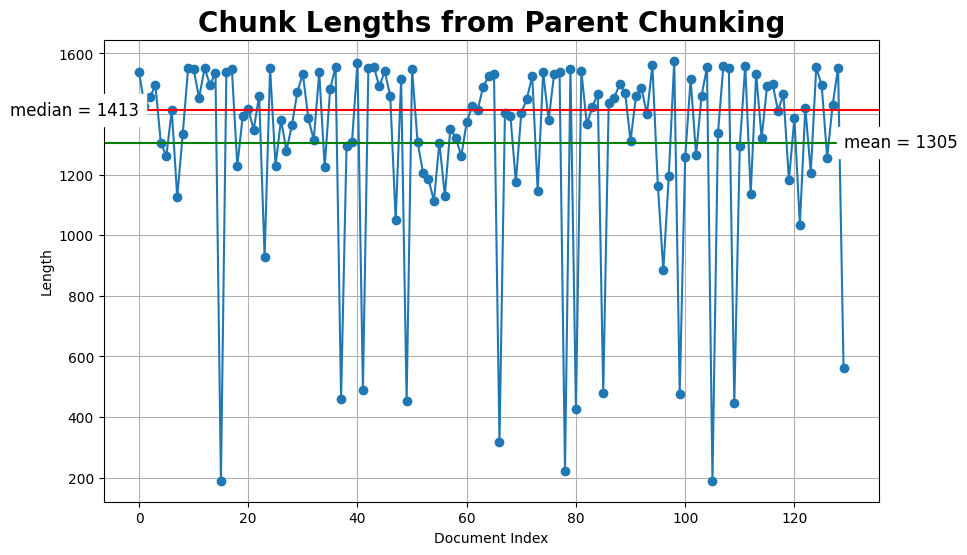

In [90]:
# Inspect chunk lengths
plot_chunk_lengths(parent_docs, 'Parent')

In [15]:
CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to use to create smaller (child) chunks
child_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    length_function = len,  # use built-in Python len function
    # separators=["\n\n"],  # split at end of paragraphs
)

# Generate the "sub" documents by splitting the original documents. 
# Store the doc_id in the metadata of the corresponding Document object.
sub_docs = []
for i, doc in enumerate(parent_docs):
    _id = doc_ids[i]
    _sub_docs = child_text_splitter.split_documents([doc])
    for _doc in _sub_docs:
        _doc.metadata[id_key] = _id
    sub_docs.extend(_sub_docs)

# # Insert HTML headers into smaller chunks (extends their "context").
# for chunk in sub_docs:
#     if chunk.page_content.startswith(chunk.metadata['h1'][:20]):
#         continue
#     metadata_str = ' '.join(str(v) for k, v in chunk.metadata.items() if k in ['h1', 'h2'])
#     chunk.page_content = f'{metadata_str} {chunk.page_content}'

print(f"{len(parent_docs)} docs split into {len(sub_docs)} child documents.")

chunk_size: 512, chunk_overlap: 51.0
228 docs split into 873 child documents.


In [16]:
# Inspect a sub_doc.
print(sub_docs[4].page_content[:200])
pprint.pprint(sub_docs[4].metadata)

using PyMilvus. Added guidance on how to enable RBAC with Milvus Operator. Added descriptions of Milvus CDC. Introducing PyMilvus Integration with Embedding Models Engineering Made with Love by the De
{'doc_id': 'ab615aaf-af19-4b50-ac9d-8bbd1d1c6d51',
 'doc_index': '5a75d188-5760-42ed-908a-b9c35c6998a2',
 'h1': 'Welcome to Milvus Docs!',
 'h2': 'Here you will learn about',
 'h3': '',
 'source': 'https://milvus.io/docs/'}


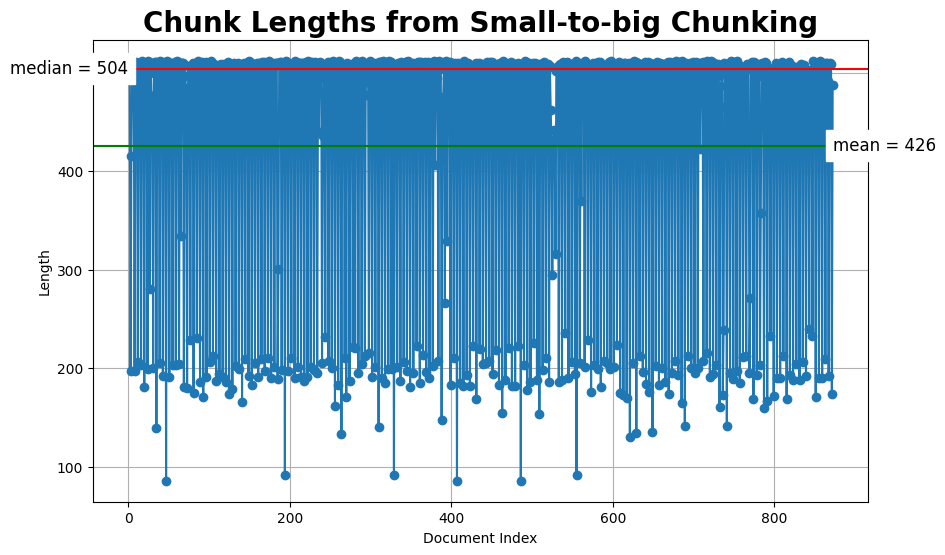

In [17]:
# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Small-to-big')

In [18]:
# Index the documents in the document store.
start_time = time.time()
retriever.docstore.mset(list(zip(doc_ids, parent_docs)))
print(f"Indexed {len(parent_docs)} parent documents in {time.time()-start_time:.2f} seconds and ")

# Index the documents in the vector store.
batch_size = 300
total_docs = len(sub_docs)
# Calculate the number of batches needed
batches = (total_docs + batch_size - 1) // batch_size
start_time = time.time()
for i in range(batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, total_docs)
    batch = sub_docs[batch_start:batch_end]
    retriever.vectorstore.add_documents(batch)

print(f"Indexed a total of {total_docs} child documents in {time.time()-start_time:.2f} seconds")

# Indexed 507 documents in 56.15 seconds.

Indexed 228 parent documents in 0.00 seconds and 
Indexed a total of 873 child documents in 116.82 seconds


In [19]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

## Semantic Chunking using LangChain

This chunker works by determining when to "break" apart sentences. This is done by calculating cosine distances between adjacent sentences. Looking across all these cosine distances, look for outlier distances past some threshold.  These outlier distances determine when chunks are split.

There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg.

- `percentile` (default) — In this method, any distances greater than X percentile is split into a chunk.

- `standard_deviation` — In this method, any difference greater than X standard deviations is split.

- `interquartile` — In this method, the interquartile distance is used to split chunks.

- See Semantic Chunking [docs](https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/#standard-deviation) and [api](https://api.python.langchain.com/en/latest/text_splitter/langchain_experimental.text_splitter.SemanticChunker.html).

In [20]:
# !python -m pip install langchain_experimental

In [21]:
# # UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# # Read docs into LangChain
# # !pip install -U langchain
# # !pip install unstructured
# from langchain.document_loaders import DirectoryLoader

# # Load HTML files from a local directory
# path = "../../RAG/rtdocs_new/"
# global_pattern = '*.html'
# loader = DirectoryLoader(path=path, glob=global_pattern)
# docs = loader.load()

# num_documents = len(docs)
# print(f"loaded {num_documents} documents")

# # # Subset docs for faster testing
# # docs = docs[5:7].copy()
# # num_documents = len(docs)
# # print(f"testing with {num_documents} documents")

# # Print the type of the docs.
# print(type(docs))
# print(type(docs[0]))

# docs[0].page_content[:500]

In [22]:
# TODO - MOVE THIS TO A LOOP
# # Extract all document content into a single string.
# all_page_contents = " ".join(doc.page_content for doc in docs)
# all_page_contents = clean_text(all_page_contents)
# # print(f"len(all_page_contents): {len(all_page_contents)}")
# # print(all_page_contents[:500])

In [23]:
# from langchain_experimental.text_splitter import SemanticChunker

# text_splitter = SemanticChunker(embed_model)
# semantic_docs = text_splitter.create_documents([all_page_contents])

# lengths = [len(doc.page_content) for doc in semantic_docs]
# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")
# print(", ".join(str(len(length)) for length in lengths))
# pprint.pprint(semantic_docs[0].page_content)
# # Created 59 semantic documents from 22.

In [24]:
# # Inspect chunk lengths
# lengths = [len(doc.page_content) for doc in html_docs]
# import matplotlib.pyplot as plt

# # Mean, median lengths.
# mean_length = np.mean(lengths)
# median_length = np.median(lengths)

# # Plotting the lengths.
# plt.figure(figsize=(10, 6))  # Adjust figure size
# plt.plot(lengths, marker='o')  # Plot normalized lengths with circle markers
# plt.title('Chunk Lengths from Semantic Chunking', fontsize=20, fontweight='bold')
# plt.xlabel('Document Index')  # X-axis label
# plt.ylabel('Normalized Length')  # Y-axis label, now showing normalized length
# plt.grid(True)  # Show grid

# # Add a horizontal red line at mean length
# plt.axhline(y=mean_length, color='g', linestyle='-')
# plt.axhline(y=median_length, color='r', linestyle='-')
# plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
# plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

# plt.show()  # Display the plot

In [25]:
# # Use Percentile to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="percentile",
#     breakpoint_threshold_amount=0.99
# )

# semantic_docs = text_splitter.create_documents([all_page_contents])
# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")

# # Too many!
# # Created 1138 semantic documents from 22.

In [26]:
# # Use Standard Deviation to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="standard_deviation",
#     breakpoint_threshold_amount=0.80
# )
# semantic_docs = text_splitter.create_documents([all_page_contents])

# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")
# print(", ".join(str(len(doc.page_content)) for doc in semantic_docs))
# pprint.pprint(semantic_docs[0].page_content)

# # Created 195 semantic documents from 22.

In [27]:
# # Create vectorstore for vector index and retrieval.
# COLLECTION_NAME = "MilvusDocs"
# start_time = time.time()
# vectorstore = Milvus.from_documents(
#     collection_name=COLLECTION_NAME,
#     documents=semantic_docs,
#     embedding=embed_model,
#     connection_args={"uri": "./milvus_demo.db"},
#     # Override LangChain default values for Milvus.
#     consistency_level="Eventually",
#     # auto_id=True,
#     drop_old=True,
#     index_params = {
#         "metric_type": "COSINE",
#         "index_type": "AUTOINDEX",
#         "params": {},}
# )
# end_time = time.time()
# print(f"Created Milvus collection from {len(semantic_docs)} docs in {end_time - start_time:.2f} seconds")

In [28]:
# Delete the Milvus collection and vectorstore.
# del vectorstore

## Ask a question about your data

So far in this demo notebook: 
1. Your custom data has been mapped into a vector embedding space
2. Those vector embeddings have been saved into a vector database

Next, you can ask a question about your custom data!

💡 In LLM vocabulary:
> **Query** is the generic term for user questions.  
A query is a list of multiple individual questions, up to maybe 1000 different questions!

> **Question** usually refers to a single user question.  
In our example below, the user question is "What is AUTOINDEX in Milvus Client?"

> **Semantic Search** = very fast search of the entire knowledge base to find the `TOP_K` documentation chunks with the closest embeddings to the user's query.

💡 The same model should always be used for consistency for all the embeddings data and the query.

In [29]:
# Define a sample question about your data.
QUESTION1 = "What do the parameters for HNSW mean?"
QUESTION2 = "What are good default values for HNSW parameters with 25K vectors dim 1024?"
QUESTION3 = "What does nlist vs nprobe mean in ivf_flat?"
QUESTION4 = "What is the default AUTOINDEX index and vector field distance metric in Milvus?"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3, QUESTION4]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"example query length: {QUERY_LENGTH}")

example query length: 75


In [68]:
# SELECT A PARTICULAR QUESTION TO ASK.

SAMPLE_QUESTION = QUESTION4

## Execute a vector search

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.

In [31]:
# # Retrieve semantic chunks.
# TOP_K = 2
# semantic_retriever = vectorstore.as_retriever(search_kwargs={"k" : TOP_K})
# semantic_results = semantic_retriever.invoke(SAMPLE_QUESTION)

# print(len(semantic_results))

# # Print the retrieved chunk and metadata.
# contexts = []
# for semantic_result in semantic_results:
#     context = semantic_result.page_content
#     print(len(context))
#     pprint.pprint(f"chunk: {context}")
#     pprint.pprint(f"metadata: {semantic_result.metadata}")
#     context = semantic_result.page_content
#     contexts.append(context)

In [69]:
# The vector store alone will retrieve small chunks:
TOP_K = 2
child_results = retriever.vectorstore.similarity_search(
    SAMPLE_QUESTION,
    k=TOP_K)

# Print the retrieved chunk and metadata.
# Append each unique context and source to a list.
contexts = []
sources = []
for child_result in child_results:
    context = child_result.page_content
    print(len(context))
    print(f"chunk: {context}")
    pprint.pprint(f"metadata: {child_result.metadata}")
    context = child_result.page_content
    contexts.append(context)
    source = child_result.metadata['source']
    if source not in sources:
        sources.append(source)

print(sources)
print(len(contexts))

512
chunk: during searches or queries. Milvus provides several index types and metrics to sort field values for efficient similarity searches. The following table lists the supported index types and metrics for different vector field types. For details, refer to In-memory Index and Similarity Metrics. Floating point embeddings Binary embeddings Sparse embeddings Metric Types Index Types Euclidean distance (L2)Inner product (IP)Cosine similarity (COSINE) FLATIVF_FLATIVF_SQ8IVF_PQGPU_IVF_FLATGPU_IVF_PQHNSWDISKANN Metric
("metadata: {'h1': 'Index Vector Fields', 'h2': 'This guide walks you thro', "
 "'h3': 'Overview', 'source': 'https://milvus.io/docs/index-vector-fields.md', "
 "'doc_index': 'c393a40d-864a-4cc4-9da3-4c53cf2d6602', 'doc_id': "
 "'6c120544-d259-4fb1-b6f2-0481de55c492', 'pk': 450852554287612165}")
498
chunk: field. index_params.add_index( field_name="vector", metric_type="COSINE", index_type="IVF_FLAT", index_name="vector_index", params={ "nlist": 128 } ) # 4.3. Create an i

In [70]:
# Whereas the retriever will return the larger parent document:
parent_results = retriever.invoke(
    SAMPLE_QUESTION)  #[0].page_content

# Print the retrieved chunk and metadata.
print(f"Num parent results: {len(parent_results)}")
for parent_result in parent_results:
    print(len(parent_result.page_content))
    print(f"chunk: {parent_result.page_content}")
    pprint.pprint(f"metadata: {parent_result.metadata}")

# Only the 0th parent chunk seems relevant.
assert parent_results[0].metadata['source'] == sources[0]

Num parent results: 4
1571
chunk: during searches or queries. Milvus provides several index types and metrics to sort field values for efficient similarity searches. The following table lists the supported index types and metrics for different vector field types. For details, refer to In-memory Index and Similarity Metrics. Floating point embeddings Binary embeddings Sparse embeddings Metric Types Index Types Euclidean distance (L2)Inner product (IP)Cosine similarity (COSINE) FLATIVF_FLATIVF_SQ8IVF_PQGPU_IVF_FLATGPU_IVF_PQHNSWDISKANN Metric Types Index Types Jaccard (JACCARD)Hamming (HAMMING) BIN_FLATBIN_IVF_FLAT Metric Types Index Types IP SPARSE_INVERTED_INDEXSPARSE_WAND It is recommended to create indexes for both the vector field and scalar fields that are frequently accessed. As explained in Manage Collections, Milvus automatically generates an index and loads it into memory when creating a collection if any of the following conditions are specified in the collection creation requ

## Summarize the context using a LLM

Using a small, open source LLM should be good enough for the summarization task.

In [71]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)

# Alternatively use the parent (bigger) chunks.
# contexts_combined = " ".join([result.page_content 
#     for result in parent_results[:TOP_K]])
# contexts_combined = parent_results[0].page_content

print(f"Length long text to summarize: {len(contexts_combined)}")

Length long text to summarize: 1011


In [72]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

# Define a system prompt to use for summarization.
SYSTEM_PROMPT = f"""First select the text that is relevant to the 
user's question.  Second, summarize the selected text so it is clear,
easy to understand, and concise, in fewer than 10 sentences.
Text: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")


Length prompt: 1196


In [73]:
print(SYSTEM_PROMPT)

First select the text that is relevant to the 
user's question.  Second, summarize the selected text so it is clear,
easy to understand, and concise, in fewer than 10 sentences.
Text: during searches or queries. Milvus provides several index types and metrics to sort field values for efficient similarity searches. The following table lists the supported index types and metrics for different vector field types. For details, refer to In-memory Index and Similarity Metrics. Floating point embeddings Binary embeddings Sparse embeddings Metric Types Index Types Euclidean distance (L2)Inner product (IP)Cosine similarity (COSINE) FLATIVF_FLATIVF_SQ8IVF_PQGPU_IVF_FLATGPU_IVF_PQHNSWDISKANN Metric field. index_params.add_index( field_name="vector", metric_type="COSINE", index_type="IVF_FLAT", index_name="vector_index", params={ "nlist": 128 } ) # 4.3. Create an index file client.create_index( collection_name="customized_setup", index_params=index_params ) import io.milvus.v2.common.IndexParam; i

In [74]:
# !python -m pip install ollama
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8B, QUANTIZATION_LEVEL:Q4_0, 



In [75]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)
ollama_llama3_time = time.time() - start_time

# Print all answers in the response.
semantic_summary = ""
semantic_summary += response['message']['content'] + " "
print(f"Answer: {semantic_summary}")
print("\n")
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

Answer: According to the provided text, there isn't a specific mention of what the default AUTOINDEX or vector field distance metric are in Milvus.

However, based on other documentation available for Milvus (https://milvus.io/docs/), it appears that:

* The default index type is IVF_PQ.
* The default distance metric used by this index is Euclidean Distance (L2).

Please note that these defaults might be subject to change or may have changed since the provided text was written. For more accurate and up-to-date information, I recommend consulting Milvus' official documentation or contacting their support team directly. 


ollama_llama3_time: 14.61 seconds


## Use an LLM to Generate a chat response to the user's question using the Retrieved Context.

Many different generative LLMs exist these days.  Check out the lmsys [leaderboard](https://chat.lmsys.org/?leaderboard).

In this notebook, we'll try these LLMs:
- The newly released open-source Llama 3 from Meta.
- The cheapest, paid model from Anthropic Claude3 Haiku.
- The standard in its price cateogory, gpt-3.5-turbo, from Openai.

In [38]:
# STEP 8. LLM-GENERATED ANSWER TO THE QUESTION, GROUNDED BY RETRIEVED CONTEXT.

# Separate all the sources together by comma.
source_combined = []
source_combined = ' '.join(reversed(sources))

# Separate all the context together by space.
# Lance Martin, LangChain, says put best contexts at end.
contexts_combined = ' '.join(reversed(contexts))

# # Alternatively use the parent (bigger) chunk.
# contexts_combined = parent_results[0].page_content

# # # Alternatively use the summary.
# contexts_combined = semantic_summary
# print(f"Length long text to summarize: {len(contexts_combined)}")

# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

In [39]:
SYSTEM_PROMPT = f"""First, check if the Context below is relevant to 
the user's question.  Second, only if the context is strongly relevant, 
answer the question using the context.  Otherwise, if the context is not 
strongly relevant, answer the question without using the context.  
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 2 sentences, and cite unique sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

Length prompt: 1465


In [40]:
# Inspect the prompt.
pprint.pprint(SYSTEM_PROMPT)

('First, check if the Context below is relevant to \n'
 "the user's question.  Second, only if the context is strongly relevant, \n"
 'answer the question using the context.  Otherwise, if the context is not \n'
 'strongly relevant, answer the question without using the context.  \n'
 'Be clear, concise, relevant.  Answer clearly, easy to understand, \n'
 'fewer than 2 sentences, and cite unique sources.\n'
 'Grounding sources: https://milvus.io/docs/index.md\n'
 'Context: at the cost of increased search time.[1, 65535]2 Common search '
 'Range search HNSW (Hierarchical Navigable Small World Graph) is a '
 'graph-based indexing algorithm. It builds a multi-layer navigation structure '
 'for an image according to certain rules. In this structure, the upper layers '
 'are more sparse and the distances between nodes are farther; the lower '
 'layers are denser and the distances between nodes are closer. The search '
 'starts from the uppermost layer, finds the node closest to the target i

# Try Meta Llama 3 with Ollama to generate a human-like chat response to the user's question

Follow the instructions to install ollama and pull a model.<br>
https://github.com/ollama/ollama

View details about which models are supported by ollama. <br>
https://ollama.com/library/llama3

That page says `ollama run llama3` will by default pull the latest "instruct" model, which is fine-tuned for chat/dialogue use cases.

The other kind of llama3 models are "pre-trained" base model. <br>
Example: ollama run llama3:text ollama run llama3:70b-text

**Format** `gguf` means the model runs on CPU.  gg = "Georgi Gerganov", creator of the C library model format ggml, which was recently changed to gguf.

**Quantization** (think of it like vector compaction) can lead to higher throughput at the expense of lower accuracy.  For the curious, quantization meanings can be found on: <br>
https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML/tree/main.  

Below just listing the main quantization types.
- **q4_0**: Original quant method, 4-bit.
- **q4_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K
- **q5_0**: Higher accuracy, higher resource usage and slower inference.
- **q5_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K
- **q 6_k**: Uses Q8_K for all tensors
- **q8_0**: Almost indistinguishable from float16. High resource use and slow. Not recommended for most users.

In [41]:
# !python -m pip install ollama
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]


# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8B, QUANTIZATION_LEVEL:Q4_0, 



In [42]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)

ollama_llama3_time = time.time() - start_time
print(response['message']['content'])
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

In Hierarchical Navigable Small World Graph (HNSW), there are two main parameters that control its behavior:

1. **M** (`max_degree`): This parameter defines the maximum number of outgoing connections in each layer of the graph. A higher value means more nodes can be connected to a single node, which increases the density and searchability of the index.
2. **ef** (Efficiency Factor): This is used during both indexing construction and target searching. It controls how much information from previous searches should be reused when traversing through layers.

In other words:

* `M` determines how many "neighbors" each node can have, which affects the graph's density and search efficiency.
* `ef` adjusts the trade-off between precision (search accuracy) and recall (completeness of results). A higher value means more information is reused from previous searches, making it faster but potentially less accurate.
ollama_llama3_time: 10.23 seconds


# Now try Anyscale endpoints


In [ ]:
# # List all the anyscale endpoint models.
# !llm models list

In [ ]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "meta-llama/Llama-3-8b-chat-hf"

# 1. Get your API key: https://platform.openai.com/api-keys
# 2. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
anyscale_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 3. Generate response using the OpenAI API.
start_time = time.time()
response = anyscale_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_anyscale_endpoints_time: {format(llama3_anyscale_endpoints_time, '.2f')} seconds")

In [ ]:
# Also try OctoAI
# !python -m pip install octoai
from octoai.text_gen import ChatMessage
from octoai.client import OctoAI

LLM_NAME = "meta-llama-3-8b-instruct"

octoai_client = OctoAI(
    api_key=os.environ.get("OCTOAI_TOKEN"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = octoai_client.text_gen.create_chat_completion(
	messages=[
		ChatMessage(
			content=SYSTEM_PROMPT,
			role="system"
		),
		ChatMessage(
			content=SAMPLE_QUESTION,
			role="user"
		)
	],
	model=LLM_NAME,
    temperature=TEMPERATURE,
    # seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_octai_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_octai_endpoints_time: {format(llama3_octai_endpoints_time, '.2f')} seconds")

In [ ]:
# Also try Groq endpoints
# !python -m pip install groq
from groq import Groq

LLM_NAME = "llama3-8b-8192"

groq_client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = groq_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_groq_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_groq_endpoints_time: {format(llama3_groq_endpoints_time, '.2f')} seconds")

## Also try Anthropic Claude3 

We've practiced retrieval for free on our own data using open-source LLMs.  <br>

Now let's make a call to the paid Claude3. [List of models](https://docs.anthropic.com/claude/docs/models-overview)
- Opus - most expensive
- Sonnet
- Haiku - least expensive!

Prompt engineering tutorials
- [Interactive](https://docs.google.com/spreadsheets/d/19jzLgRruG9kjUQNKtCg1ZjdD6l6weA6qRXG5zLIAhC8/edit#gid=150872633)
- [Static](https://docs.google.com/spreadsheets/d/1jIxjzUWG-6xBVIa2ay6yDpLyeuOh_hR_ZB75a47KX_E/edit#gid=869808629)

In [ ]:
# SYSTEM_PROMPT = f"""Use the Context below to answer the user's question. 
# Be clear, factual, complete, concise.
# If the answer is not in the Context, say "I don't know". 
# Otherwise answer with fewer than 4 sentences and cite the unique sources.
# Context: {contexts_combined}
# Sources: {source_combined}

# Answer with 2 parts: the answer and the source citations.
# Answer: The answer to the question.
# Sources: unique url sources
# """

In [ ]:
# # !python -m pip install anthropic
# import anthropic

# ANTHROPIC_API_KEY=os.environ.get("ANTHROPIC_API_KEY")

# # # Model names
# # claude-3-opus-20240229
# # claude-3-sonnet-20240229
# # claude-3-haiku-20240307
# CLAUDE_MODEL = "claude-3-haiku-20240307"
# print(f"Model: {CLAUDE_MODEL}")
# print()

# client = anthropic.Anthropic(
#     # defaults to os.environ.get("ANTHROPIC_API_KEY")
#     api_key=ANTHROPIC_API_KEY,
# )

# # Print the question and answer along with grounding sources and citations.
# print(f"Question: {SAMPLE_QUESTION}")

# # CAREFUL!! THIS COSTS MONEY!!
# message = client.messages.create(
#     model=CLAUDE_MODEL,
#     max_tokens=1000,
#     temperature=0.0,
#     system=SYSTEM_PROMPT,
#     messages=[
#         {"role": "user", "content": SAMPLE_QUESTION}
#     ]
# )
# print("Answer:")
# pprint.pprint(message.content[0].text.replace('\n', ' '))

<div>
<img src="../../../images/anthropic_claude3.png" width="80%"/>
</div>

## Also try MistralAI's Mixtral 8x7B-Instruct-v0.1

This time ollama's version requires 48GB RAM. If you have big enough compute, run the command:
> ollama run mixtral

Since my laptop is a M2 with only 16GB RAM, I decided to **run Mixtral using Anyscale Endpoints**. Instructions to install. <br>
> https://github.com/simonw/llm-anyscale-endpoints

To get back to **Anyscale Endpoints** anytime, open the playground.<br>
https://console.anyscale.com/v2/playground

In [ ]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "mistralai/Mixtral-8x7B-Instruct-v0.1"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
mixtral_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"mixtral_anyscale_endpoints_time: {format(mixtral_anyscale_endpoints_time, '.2f')} seconds")

<div>
<img src="../../../images/mistral_mixtral.png" width="80%"/>
</div>

## Also try OpenAI

💡 Note: For use cases that need to always be factually grounded, use very low temperature values while more creative tasks can benefit from higher temperatures.

In [43]:
SYSTEM_PROMPT = f"""First, check if the Context below is relevant to 
the user's question.  Second, only if the context is strongly relevant, 
answer the question using the context.  Otherwise, if the context is not 
strongly relevant, answer the question without using the context.
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 4 sentences, and cite unique grounding sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""

In [44]:
pprint.pprint(SYSTEM_PROMPT)

('First, check if the Context below is relevant to \n'
 "the user's question.  Second, only if the context is strongly relevant, \n"
 'answer the question using the context.  Otherwise, if the context is not \n'
 'strongly relevant, answer the question without using the context.\n'
 'Be clear, concise, relevant.  Answer clearly, easy to understand, \n'
 'fewer than 4 sentences, and cite unique grounding sources.\n'
 'Grounding sources: https://milvus.io/docs/index.md\n'
 'Context: at the cost of increased search time.[1, 65535]2 Common search '
 'Range search HNSW (Hierarchical Navigable Small World Graph) is a '
 'graph-based indexing algorithm. It builds a multi-layer navigation structure '
 'for an image according to certain rules. In this structure, the upper layers '
 'are more sparse and the distances between nodes are farther; the lower '
 'layers are denser and the distances between nodes are closer. The search '
 'starts from the uppermost layer, finds the node closest to the 

In [45]:
import openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
# Customers using the pinned gpt-3.5-turbo model alias will be automatically upgraded to gpt-3.5-turbo-0125 two weeks after this model launches.
LLM_NAME = "gpt-3.5-turbo"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
chatgpt_35turbo_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    pprint.pprint(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_3.5_turbo_time: {format(chatgpt_35turbo_time, '.5f')}")

# Question1: What do the parameters for HNSW mean?
# Answer:  Looks perfect!
# Best answer:  M: maximum degree of nodes in a layer of the graph. 
# efConstruction: number of nearest neighbors to consider when connecting nodes in the graph.
# ef: number of nearest neighbors to consider when searching for similar vectors. 

# Question2: What are good default values for HNSW parameters with 25K vectors dim 1024?
# Answer: M=16, efConstruction=500, and ef=64
# Best answer:  M=16, efConstruction=32, ef=32

# Question3: what is the default distance metric used in AUTOINDEX in Milvus?
# Answer: L2 
# Best answer:  IP inner product, not yet updated in documentation still says L2.

# Question4: What does nlist mean in ivf_flat?
# 'Answer: In IVF_FLAT, nlist refers to the number of cluster units that divide '
#  'a vector space. When using the default value of 16384 for nlist in Milvus, '
#  "distances between the target vector and all 16384 clusters' centers are "
#  'compared to find the nearest clusters for further comparison with vectors '
#  'within those selected clusters. This parameter influences how clustering is '
#  'performed and affects search efficiency in Milvus.\n'
#  'Sources: https://milvus.io/docs/index.md')

Question: What do the parameters for HNSW mean?
('Answer: In the context of HNSW (Hierarchical Navigable Small World Graph), '
 'the parameters are as follows:\n'
 '- M: It defines the maximum number of outgoing connections in the graph. A '
 'higher M value leads to increased recall but also increases search time.\n'
 '- efConstruction: This parameter is used when building an index and '
 'specifies a search range for constructing the graph.\n'
 '- ef: This parameter is used when searching for targets and specifies a '
 'search range to find nearest neighbors efficiently.\n'
 '\n'
 'Source:\n'
 'https://milvus.io/docs/index.md')


chatgpt_3.5_turbo_time: 1.98639


## Use Ragas to evaluate RAG pipeline

Ragas is an open source project for evaluating RAG components.  [Paper](https://arxiv.org/abs/2309.15217), [Code](https://docs.ragas.io/en/stable/getstarted/index.html), [Docs](https://docs.ragas.io/en/stable/getstarted/index.html), [Intro blog](https://medium.com/towards-data-science/rag-evaluation-using-ragas-4645a4c6c477).

<div>
<img src="../../../images/ragas_eval_image.png" width="80%"/>
</div>

**Please note that RAGAS can use a large amount of OpenAI api token consumption.** <br> 

Read through this notebook carefully and pay attention to the number of questions and metrics you want to evaluate.



In [ ]:
# !python -m pip install -U ragas dataset

In [76]:
import os, sys
import pandas as pd
import numpy as np
import ragas, datasets
from langchain_huggingface import HuggingFaceEmbeddings
from ragas.embeddings import LangchainEmbeddingsWrapper

# Import custom functions for evaluation.
sys.path.append("../../Integration")  
import eval_ragas as _eval_ragas

# Import the evaluation metrics.
from ragas.metrics import (
    context_recall, 
    context_precision, 
    faithfulness, 
    answer_relevancy, 
    answer_similarity,
    answer_correctness
    )

# Get the current working directory.
cwd = os.getcwd()
relative_path = '/../../Evaluation/data/blog_eval_answers.csv'
file_path = cwd + relative_path
# print(f"file_path: {file_path}")

# Read ground truth answers from file.
eval_df = pd.read_csv(file_path, header=0, skip_blank_lines=True)
display(eval_df.head())

,Question,ground_truth_answer,naive_context_k_2,html_context_k_2,parent_context_k1,html_context_k_2_summary,semantic_context_k2_summary,parent_context_k1_text-embedding-3-small,Custom_RAG_answer,llama3_ollama_answer,llama3_anyscale_answer,llama3_octoai_answer,llama3_groq_answer,mixtral_8x7b_anyscale_answer
0,What do the parameters for HNSW mean?,"* M: maximum degree, or number of connections ...","In order to improve performance, HNSW limits t...","the node closest to the target in this layer, ...",Search parameters ParameterDescriptionRangeDef...,* `M`: defines maximum number of outgoing conn...,The three main parameters for Hierarchical Nav...,"In order to improve performance, HNSW limits t...",In the context of HNSW (Hierarchical Navigabl...,* **M** controls the graph's density and compu...,* M: defines the maximum number of outgoing co...,* M: defines the maximum number of outgoing co...,* M: defines the maximum number of outgoing co...,* The `M` parameter in `MM` defines the maximu...
1,What are good default values for HNSW paramete...,"M=16, efConstruction=32, ef=32","When conducting searches, note that you can se...","first. When conducting searches, note that you...",between the target vector and the clustering c...,* `nlist`: Set to a moderate value such as 128...,For an index built on top of a dataset with ap...,Index building parameters Parameter Descriptio...,- M = 32 - efConstruction = 100,M=16\nefConstruction=128 ef=64,* M: 16 * efConstruction: 100 * ef: top_k,* M: 16 * efConstruction: 100 * ef: top_k,* M: 16 * efConstruction: 100 * ef: 100,- M: 16 - efConstruction: 100 - ef: 50
2,What does nlist vs nprobe mean in ivf_flat?,# nlist: controls how the vector data is part...,"By adjusting nprobe, an ideal balance between ...",FLAT index and IVF_FLAT index? IVF_FLAT index ...,FLAT index and IVF_FLAT index? IVF_FLAT index ...,"* `NLIST`: controls how many initial ""buckets""...","In IVF_FLAT, `nlist` (short for ""number of lis...","By adjusting nprobe, an ideal balance between ...",- nlist in IVF_FLAT refers to the number of cl...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...,- `nlist` refers to the number of cluster unit...
3,What is the default AUTOINDEX index and vector...,Index type = HNSW and distance metric=IP Inner...,Leveraging the metadata stored in an index fil...,during searches or queries. Milvus provides se...,during searches or queries. Milvus provides se...,"According to the provided text, there are no s...","According to the provided text, there isn't a ...",Why Milvus Docs Tutorials Tools Blog Community...,The default AUTOINDEX index in Milvus is IVF_S...,The default `AUTOINDEX` index uses a combinati...,"According to the Milvus documentation, the def...","According to the Milvus documentation, the def...","According to the Milvus documentation, the def...",The default AUTOINDEX index in Milvus is an An...


In [81]:
##########################################
# Set the evaluation type.
EVALUATE_WHAT = 'ANSWERS' 
EVALUATE_WHAT = 'CONTEXTS'
##########################################

# Set the columns to evaluate.
if EVALUATE_WHAT == 'CONTEXTS':
    cols_to_evaluate=\
    ['naive_context_k_2', 'html_context_k_2', 'parent_context_k1', 
     'html_context_k_2_summary', 'semantic_context_k2_summary']
elif EVALUATE_WHAT == 'ANSWERS':
    cols_to_evaluate=['Custom_RAG_answer', 'llama3_ollama_answer', 
                      'llama3_anyscale_answer', 'llama3_octoai_answer',
                      'llama3_groq_answer', 'mixtral_8x7b_anyscale_answer']

# Set the metrics to evaluate.
if EVALUATE_WHAT == 'ANSWERS':
    eval_metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        faithfulness,
        ]
    metrics = ['answer_relevancy', 'answer_similarity', 'answer_correctness', 'faithfulness']
elif EVALUATE_WHAT == 'CONTEXTS':
    eval_metrics=[
        context_recall, 
        context_precision,
        ]
    metrics = ['context_recall', 'context_precision']
    
# Change the default the llm-as-critic model.
LLM_NAME = "gpt-3.5-turbo"
ragas_llm = ragas.llms.llm_factory(model=LLM_NAME)

# Change the default embeddings models to HuggingFace models.
EMB_NAME = "BAAI/bge-large-en-v1.5"
# Define the embedding model.
EMB_NAME = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
lc_embed_model = HuggingFaceEmbeddings(
    model_name=EMB_NAME,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
ragas_emb = LangchainEmbeddingsWrapper(embeddings=lc_embed_model)

# Change embeddings and critic models for each metric.
for metric in metrics:
    globals()[metric].llm = ragas_llm
    globals()[metric].embeddings = ragas_emb

# Execute the evaluation.
print(f"Evaluating {EVALUATE_WHAT} using {eval_df.shape[0]} eval questions:")
ragas_result, scores = _eval_ragas.evaluate_ragas_model(
    eval_df, 
    eval_metrics, 
    what_to_evaluate=EVALUATE_WHAT,
    cols_to_evaluate=cols_to_evaluate)

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluating CONTEXTS using 4 eval questions:


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: naive_context_k_2, avg_score: 0.57


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: html_context_k_2, avg_score: 0.54


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: parent_context_k1, avg_score: 0.42


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: html_context_k_2_summary, avg_score: 0.42


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: semantic_context_k2_summary, avg_score: 0.42


In [ ]:
print(type(scores))
print(scores)
# scores[1]['parent_context_k1']
# scores[3]['semantic_context_k2_summary']

In [83]:
# Calculate and print the percent improvements.
if EVALUATE_WHAT == 'ANSWERS':
    # Sort scores from highest to lowest
    sorted_scores = sorted(scores, key=lambda item: sum(item.values()), reverse=True)
    pprint.pprint(sorted_scores)
    # Calculate the percent improvement of the best LLM over the worst LLM.
    highest_score = list(sorted_scores[0].values())[0]
    lowest_score = list(sorted_scores[-1].values())[0]
    best_llm = list(sorted_scores[0].keys())[0]
    worst_llm = list(sorted_scores[-1].keys())[0]
    percent_better = (highest_score - lowest_score) / lowest_score * 100
    print(f"{best_llm} {np.round(percent_better,0)}% improvement over {worst_llm}.")

elif EVALUATE_WHAT == 'CONTEXTS':
    pprint.pprint(scores)
    percent_better = (scores[0]['naive_context_k_2'] - scores[3]['html_context_k_2_summary']) \
                     / scores[3]['html_context_k_2_summary'] * 100
    # percent_better = (scores[0]['parent_context_k1'] - scores[1]['parent_context_k1_text-embedding-3-small']) \
    #                  / scores[1]['parent_context_k1_text-embedding-3-small'] * 100
    print(f"Chunking {np.round(percent_better,0)}% improvement.")

# Display the evaluation details.
display(ragas_result)

[{'naive_context_k_2': 0.57},
 {'html_context_k_2': 0.54},
 {'parent_context_k1': 0.42},
 {'html_context_k_2_summary': 0.42},
 {'semantic_context_k2_summary': 0.42}]
Chunking 36.0% improvement.


,question,contexts,answer,ground_truth,context_recall,context_precision,context_f1,evaluated
0,What do the parameters for HNSW mean?,"[In order to improve performance, HNSW limits ...",In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,naive_context_k_2
1,What are good default values for HNSW paramete...,"[When conducting searches, note that you can s...",- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.333333,1.0,0.500000,naive_context_k_2
2,What does nlist vs nprobe mean in ivf_flat?,"[By adjusting nprobe, an ideal balance between...",- nlist in IVF_FLAT refers to the number of cl...,# nlist: controls how the vector data is part...,0.666667,1.0,0.800000,naive_context_k_2
3,What is the default AUTOINDEX index and vector...,[Leveraging the metadata stored in an index fi...,The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,0.000000,1.0,0.000000,naive_context_k_2
4,What do the parameters for HNSW mean?,"[the node closest to the target in this layer,...",In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,html_context_k_2
5,What are good default values for HNSW paramete...,"[first. When conducting searches, note that yo...",- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.333333,1.0,0.500000,html_context_k_2
6,What does nlist vs nprobe mean in ivf_flat?,[FLAT index and IVF_FLAT index? IVF_FLAT index...,- nlist in IVF_FLAT refers to the number of cl...,# nlist: controls how the vector data is part...,0.500000,1.0,0.666667,html_context_k_2
7,What is the default AUTOINDEX index and vector...,[during searches or queries. Milvus provides s...,The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,0.000000,1.0,0.000000,html_context_k_2
8,What do the parameters for HNSW mean?,[Search parameters ParameterDescriptionRangeDe...,In the context of HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,parent_context_k1
9,What are good default values for HNSW paramete...,[between the target vector and the clustering ...,- M = 32 - efConstruction = 100,"M=16, efConstruction=32, ef=32",0.000000,1.0,0.000000,parent_context_k1


In [ ]:
########### CHANGE THE CHUNKING STRATEGY ###########
# F1-Score 'naive_context_k_2': 0.57  (36% improvement)
# F1-Score 'html_context_k_2': 0.54
# F1-Score 'parent_context_k1': 0.42
# F1-Score 'html_context_k_2_summary': 0.42
# F1-Score 'semantic_context_k2_summary': 0.42
####################################################

########### CHANGE THE EMBEDDING MODEL #############
# F1-Score 'naive_context_k_2': 0.57  (27% improvement)
# F1-Score 'pnaive_context_k_2_text-embedding-3-small': 0.45
####################################################

############## CHANGE THE LLM ######################
# Avg mistralai mixtral_8x7b_instruct score = 0.7031 (6% improvement over gpt-3.5-turbo)
# Avg llama3_70b_anyscale_chat score = 0.6888
# Avg llama3_70b_groq_instruct score = 0.6867
# Avg llama_3_70b_octoai_instruct score = 0.6863
# Avg llama_3_8b_ollama_instruct score = 0.6783
# Avg openai gpt-3.5-turbo score = 0.665 
####################################################

In [ ]:
# Delete the Milvus collection and doc store.
del vectorstore, retriever, store

In [ ]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark

%load_ext watermark
%watermark -a 'Christy Bergman' -v -p unstructured,lxml,torch,pymilvus,langchain,ollama,octoai,groq,openai --conda